## Support Vector Machine - Face Recognition

***Author: Rabindra Nepal***

*Format prepared by: M. R. Hasan*

This notebook discusses the use of Support Vector Machine (SVM) to solve a face recognition problem: given the picture of the face of an unknown person, identify the name of the person by referring to a gallery of previously seen pictures of identified persons.

### Dataset

We will use the Labeled Faces in the Wild (LFW) people dataset:
http://vis-www.cs.umass.edu/lfw/

Labeled Faces in the Wild (LFW) is a database of face photographs designed for studying the problem of unconstrained face recognition. This database was created and maintained by researchers at the University of Massachusetts, Amherst. 13,233 images of 5,749 people were detected and centered by the Viola Jones face detector and collected from the web. 1,680 of the people pictured have two or more distinct photos in the dataset. The original database contains four different sets of LFW images and also three different types of "aligned" images. According to the researchers, deep-funneled images produced superior results for most face verification algorithms compared to the other image types. Hence, the dataset is the deep-funneled version.

Each image is a 250 x 250 jpg, detected and centered using the openCV implementation of Viola-Jones face detector. 


### Load Dataset using Scikit-Learn

This dataset can be obtained by using the Scikit-Learn function: sklearn.datasets.fetch_lfw_people

Following are the relevant return attributes:

- data: numpy array of shape (13233, 2914)
        -- Each row corresponds to a ravelled face image of original size 62 x 47 pixels. Changing the slice_ or resize parameters will change the shape of the output.

- images : numpy array of shape (13233, 62, 47)
         -- Each row is a face image corresponding to one of the 5749 people in the dataset. Changing the slice_ or resize parameters will change the shape of the output.

- target : numpy array of shape (13233,)
        -- Labels associated to each face image. Those labels range from 0-5748 and correspond to the person IDs.
        
        
We will use a **subset of this database**. The subset will only retain pictures of people that have **at least 50 different pictures**. The subset will define a 12 class classification problem.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# You may load additional libraries
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

## Load Data

We will set the values of the "min_faces_per_person" attribute to 50. This will ensure that the extracted dataset will only retain pictures of people that have at least min_faces_per_person different pictures.

This subset will define a 12 class classification problem.

In [361]:
faces = fetch_lfw_people(min_faces_per_person=50)

X = faces.data
y = faces.target

print("\nLabel of the 12 Classes:\n", faces.target_names)
print("\nData Matrix Dimension: ", X.shape)
print("\nLength of the Class Label Array:", y.shape)


Label of the 12 Classes:
 ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']

Data Matrix Dimension:  (1560, 2914)

Length of the Class Label Array: (1560,)


In [362]:
faces['target_names']

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
       'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
       'Serena Williams', 'Tony Blair'], dtype='<U17')

In [363]:
np.unique(faces['target'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

## Visualize the Images

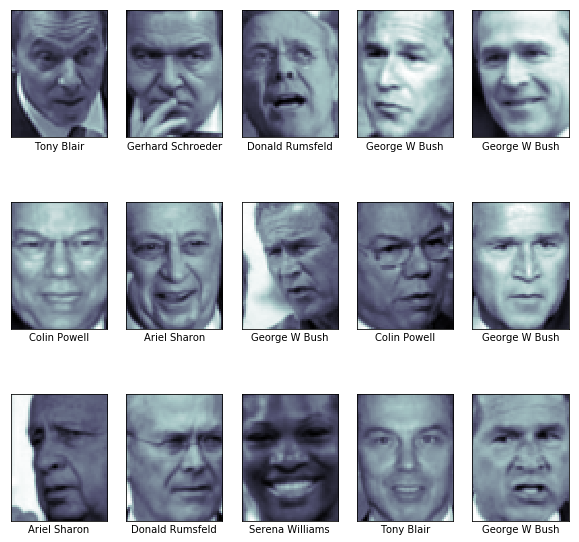

In [364]:
fig, ax = plt.subplots(3, 5)

fig.set_figheight(10)
fig.set_figwidth(10)

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [365]:
# data normalization first
scaler = StandardScaler()
# fitting
scaler.fit(X)
# Apply transform to both the training set and the test set.
X = scaler.transform(X)

## Split Training and Test Data

In [366]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [367]:
print('n_samples, n_features = ', X_train.shape)

n_samples, n_features =  (1326, 2914)


### PCA?

As seen above, the number of training image samples (1326) in this case is less than the number of features (2914). Therefore, PCA is applicable in this case and it should possibly help to improve the model performance. The number of principle components should be less than the number of observations 1326. Hence, PCA helps to reduce the feature dimension less than 1326.

In [368]:
# data normalization first
scaler = StandardScaler()
# fitting
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [369]:
pca = PCA(n_components=150, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [370]:
# keeping >95% variance in the dataset
pca.explained_variance_ratio_.sum()

0.945493

In [371]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Let us first check the model performance with PCA. We will compare the performance without PCA later and decide whether to use it or not in the optimal model.

## Eigenfaces

projection of images into the few important principle components axes.

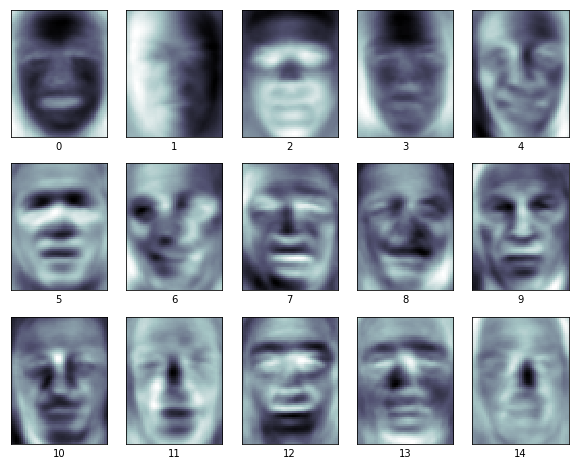

In [426]:
fig, ax = plt.subplots(3, 5)

fig.set_figheight(8)
fig.set_figwidth(10)

for i, axi in enumerate(ax.flat):
    axi.imshow(pca.components_[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=i)

#### Base model testing with LinearSVC

In [373]:
model = LinearSVC()
model.fit(X_train_pca, y_train)

C:\Users\nepal\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [374]:
# prediction on test data
y_pred = model.predict(X_test_pca)

In [376]:
confusion_matrix(y_test, y_pred)

array([[ 4,  0,  0,  1,  0,  0,  0,  0,  2,  0,  0,  0],
       [ 0, 31,  1,  3,  1,  0,  2,  0,  0,  0,  0,  0],
       [ 1,  0, 12,  4,  2,  0,  0,  2,  0,  0,  0,  0],
       [ 0,  4,  5, 65,  3,  0,  0,  0,  1,  1,  1,  4],
       [ 0,  0,  0,  1,  6,  3,  1,  1,  0,  1,  0,  1],
       [ 0,  2,  0,  2,  0,  8,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  7,  0,  0,  0,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  1,  7,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  3,  1,  0],
       [ 0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  3,  0],
       [ 0,  2,  1,  1,  1,  0,  2,  0,  0,  1,  1, 18]], dtype=int64)

In [427]:
print(classification_report(y_test, y_pred, target_names=faces['target_names']))

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.57      0.62         7
     Colin Powell       0.76      0.82      0.78        38
  Donald Rumsfeld       0.63      0.57      0.60        21
    George W Bush       0.82      0.77      0.80        84
Gerhard Schroeder       0.46      0.43      0.44        14
      Hugo Chavez       0.67      0.67      0.67        12
   Jacques Chirac       0.17      0.33      0.22         3
    Jean Chretien       0.64      0.88      0.74         8
    John Ashcroft       0.64      0.70      0.67        10
Junichiro Koizumi       0.43      0.60      0.50         5
  Serena Williams       0.50      0.60      0.55         5
       Tony Blair       0.78      0.67      0.72        27

        micro avg       0.71      0.71      0.71       234
        macro avg       0.60      0.63      0.61       234
     weighted avg       0.72      0.71      0.71       234



#### Best model search

Hyperparameters: gamma and C

Here, we will search the best hyperparameters for Gaussian RBF kernel. We will mainly concentrate on finding the correct set of gamma and C. Since gamma represents the inverse radius of the influence of each training sample in the model by the support vectors, it is one of the important parameters to tune. Due to the danger of overfitting model, which can't be resolved only by the parameter C, we usually start with smaller values of gamma and regularize the model with larger value of C. Therefore, by considering these important information, we carry out the intelligent GridSearchCV for the best values of gamma and C.

In [354]:
%%time

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)

C:\Users\nepal\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 3min 7s


In [356]:
clf.best_params_

{'C': 1000.0, 'gamma': 0.005}

In [421]:
# Best model

clf = SVC(C=1000, gamma=0.005, kernel='rbf')

In [422]:
clf.fit(X_train_pca, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Evaluate Model Performance on Test Data


In [423]:
# Confusion matrix
y_test_pred = clf.predict(X_test_pca)
confusion_matrix(y_test, y_test_pred)

array([[ 6,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 34,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  3, 15,  2,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  3,  1, 78,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  3, 10,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  2,  0,  3,  0,  7,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  9,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  4,  0,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0, 24]], dtype=int64)

In [424]:
print(classification_report(y_test, y_test_pred, target_names=faces['target_names']))

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.86      0.86         7
     Colin Powell       0.76      0.89      0.82        38
  Donald Rumsfeld       0.94      0.71      0.81        21
    George W Bush       0.80      0.93      0.86        84
Gerhard Schroeder       0.91      0.71      0.80        14
      Hugo Chavez       1.00      0.58      0.74        12
   Jacques Chirac       0.50      0.33      0.40         3
    Jean Chretien       1.00      0.88      0.93         8
    John Ashcroft       0.90      0.90      0.90        10
Junichiro Koizumi       1.00      0.80      0.89         5
  Serena Williams       1.00      0.60      0.75         5
       Tony Blair       0.96      0.89      0.92        27

        micro avg       0.85      0.85      0.85       234
        macro avg       0.89      0.76      0.81       234
     weighted avg       0.86      0.85      0.84       234



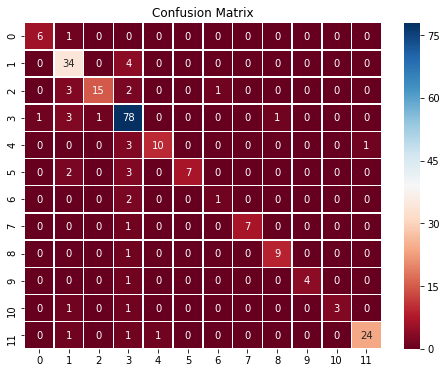

In [425]:
# confusion matrix heatmap

plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, cmap='RdBu', linewidths=0.5, fmt=".5g");
plt.title('Confusion Matrix');

### Summary of the Techniques & Model Parameters

#### Scaling
We scaled the data because we are also implementing PCA - for which PCA is crucial. PCA is a variance maximizing technique, therefore, if we don't normalize the data the features will have very unequal data variance with even a single feature spanning the most of the variance in the dataset minimizing the effect of other features. That's why, data scaling is important before using PCA.

#### PCA:

We apply PCA here. The number of features in the dataset (vectorized image) is very large - even larger than the number of training sample. Therefore, PCA is expected to be useful by both the performance and reducing the computational time as well. 

#### PCA number of components:
In order to maintain the 95% of variance of the original dataset, we have chosen the number of principle components to be 160.

#### SVM model:
Here, we initially start with the LinearSVC model as the base case which gives us the accuracy of about 72%. We then search for the SVM with non-linear kernel - Gaussian RBF. WIth this SVM model, we tune the two important parameters of the model: gamma and C out of an intelligently selected range of values from GridSearchCV.

#### SVM optimal hyperparameters:

gamma: 0.005, C: 1000

***Done!***